# Base and Standard Annotators

In [1]:
# import required packages
import sys
sys.path.append("../..")
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from annotlib import StandardAnnot

from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, confusion_matrix

# set random state to reproduce results
random_state = np.random.RandomState(42)

In a real-world scenario, an annotator is often a human who is asked to provide class labels for samples.
The *annotlib* package represents and simulates such annotators within a Python environment.

The interface respectively abstract class named [BaseAnnot](../annotlib.base.rst) is the root of all annotators as it defines the required functions of an annotator. 

In the following, you will see examples about how define a standard annotators, how to query, and how to take a look at the annotators performance.
The standard annotators represent the simplest implementation of annotators and 
are instances of the class [StandardAnnot](../annotlib.standard.rst), which enables to define arbitrary annotators.

Before we start with the annotators, we need a dataset.
Let's generate a two-dimensional (`n_features=2`) data set with `n_samples=200` samples and `n_classes=4` classes.

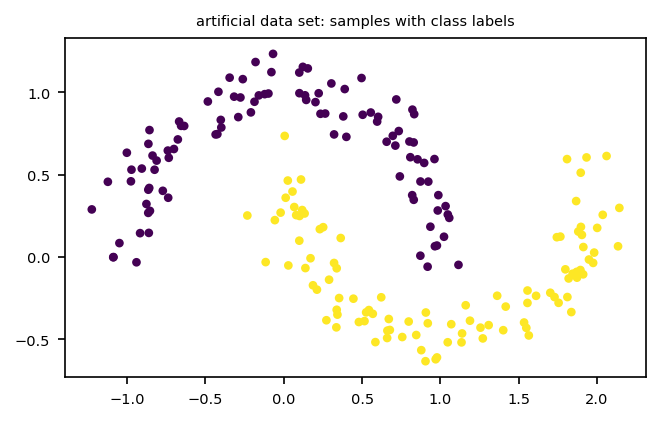

In [2]:
# data set of 200 samples
X, y_true = make_moons(200, noise=.1, random_state=random_state)
plt.figure(figsize=(5, 3), dpi=150)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y_true, s=10)
plt.title('artificial data set: samples with class labels', fontsize=7)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.show()

## Defintion of Standard Annotators
In general, an instance of the [StandardAnnot](../annotlib.standard.rst) class is comparable to a database of samples `X`, class labels `Y`, and confidence scores `C`. All of them are represented as arrays:

- samples `X`: numpy.ndarray, shape (`n_samples`, `n_features`),
- class labels `Y`: numpy.ndarray, shape (`n_samples`, `n_annotators`),
- and confidence scores `C`: numpy.ndarray, shape (`n_samples`, `n_annotators`).

To specify standard annotators, we are asked to define these arrays, which are also the attributes of an instance of the [StandardAnnot](../annotlib.standard.rst) class.
**An important remark is that the samples, class labels, and confidence scores are passed by reference.**
As a result, modifying these arrays will also lead to a modification of the attributes of the annotators.
The creation of an annotator instance is simple.

In [3]:
# class labels of three annotators
n_annotators = 3
Y = random_state.randint(0, 2, size=600).reshape(200, n_annotators)
Y[:, 0] = y_true

# confidence scores of three annotators
C = random_state.uniform(0, 1, size=600).reshape(200, n_annotators)

# use samples X, labels Y, and certainties C to create instance of StandardAnnot
std_annot = StandardAnnot(X=X, Y=Y, C=C, random_state=random_state)

At this stage, we have `n_annotators=3` annotators $\{a_0,a_1,a_2\}$ of which annotator $a_0$ is omniscient. In other words, this annotator provides only correct class labels. 

## Number of Annotators
To obtain the number of annotators, the abstract class [BaseAnnot](../annotlib.base.rst) provides a method called `n_annotators()`.

In [4]:
# get number of annotators
print('number of annotators: ' + str(std_annot.n_annotators()))

number of annotators: 3


## Class Labels and Certainty Scores
The three annotators are able to provide class labels `Y` and confidence scores `C` for given samples `X`.
For this purpose, we apply the two methods `class_labels(...)` and `confidence_scores(...)`.
These methods represent the main functions of annotators, since an annotator's main task is the labelling of samples. Moreover, an annotator is often requested to additionally provide a confidence score describe the certainty of the annotator's decision on assigning a sample to a specific class.

In [5]:
# sample of interest
X_queried = X[20].reshape(1, -1)

# query annotator with id 0 and annotator with 2 for the class labels 
# of the sample of interest
Y_queried = std_annot.class_labels(X=X_queried, annotator_ids=[0, 2], 
                                   query_value=1)
print('queried class labels: '+str(Y_queried))

# let annotator with id 0 and annotator with 2 provide confidence scores 
# of the sample of interest
C_queried = std_annot.confidence_scores(X=X_queried, annotator_ids=[0, 2])
print('queried confidence scores: '+str(C_queried))

queried class labels: [[ 1. nan  1.]]
queried confidence scores: [[0.79072316        nan 0.62589138]]


The above example shows how to query the class labels and confidence scores of a single sample. The returned labels and confidence scores have the shape `(n_queried_samples, n_annotators)`. Moreover, there are so-called `annotator_ids` and a `query_value` given. The `annotator_ids` indicate which annotators are asked and the `query_value` represents the increase of the number of queries posed to the asked annotators.
If an annotator is not asked, the label and confidence score returned by this annotator is the *Numpy* implementation of `nan`.
There may be also a scenario in which an annotator has not the knowledge to label a sample or refuses labelling the sample. 
In that case, the annotator also returns `nan` as label and as confidence score.

## Query Statistics and Queried Samples
The recording of the number of queries posed to an annotator may be useful to analyse the distribution of the queries among the available annotators.
To test this property, we look at the query statistics `n_queries()` of the annotators.

In [6]:
print('query statistics: '+str(std_annot.n_queries()))

query statistics: [1 0 1]


Provided that the method `class_label()` is executed once, the query statistics show that the annotators $a_0$ and $a_2$ were asked a single time and annotator $a_1$ has not been asked for labelling a sample yet. Correspondingly, the parameter `query_value` of the method `class_labels(...)` specifies the increase in the query statistics `n_queries()`. Another important statistic may be also for which samples an annotator was asked to provide class labels.

In [7]:
X_queried_per_annotator = std_annot.queried_samples()
print('queried samples of annotator a_0: '+str(X_queried_per_annotator[0]))
print('queried samples of annotator a_1: '+str(X_queried_per_annotator[1]))
print('queried samples of annotator a_2: '+str(X_queried_per_annotator[2]))

queried samples of annotator a_0: [[ 0.33803005 -0.06837193]]
queried samples of annotator a_1: []
queried samples of annotator a_2: [[ 0.33803005 -0.06837193]]


The queried samples are registered by the `queried_samples()` method, if the corresponding `query_value` was greater than zero.

## Labelling Performance
The labelling performance of an annotator is an interesting statistic, since it indicates which annotators should be queried for class labels. However, the performance measure depends on the objective of the application. Therefore, the annotators may be evaluated by a user-defined performance function `perf_func(y_true, y_pred)`. This function template is generally satisfied by the functions in the metrics package of *scikit-learn*. Exemplary, we use the accuracy and the confusion matrix as performance measures. There are also two methods named `plot_labelling_accuracy(...)` and `plot_labelling_confusion_matrices(...)` plotting the labelling accuracy respectively the confusion matrix of each annotator.

accuracies: [1.0, 0.55, 0.565]


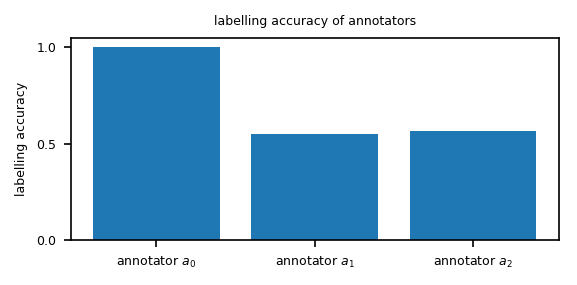

confusion matrices: [array([[100,   0],
       [  0, 100]]), array([[58, 42],
       [48, 52]]), array([[61, 39],
       [48, 52]])]


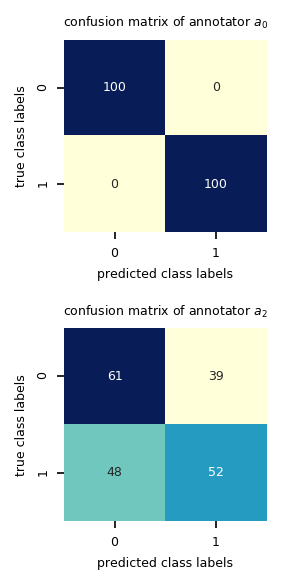

In [8]:
# accuracy as performance measure
acc = std_annot.labelling_performance(X=X, y_true=y_true, 
                                      perf_func=accuracy_score)
# plot accuracy directly
fig, ax = std_annot.plot_labelling_accuracy(X=X, y_true=y_true, 
                                            figsize=(4, 2), fontsize=6)
print('accuracies: '+str(acc))
plt.tight_layout()
plt.show()

# confusion matrix as performance measure
conf_matrices = std_annot.labelling_performance(X=X, y_true=y_true, 
                                                perf_func=confusion_matrix)
y_unique = np.unique(y_true)
fig, ax = std_annot.plot_labelling_confusion_matrices(X=X, y_true=y_true,
                                                      annotator_ids=[0, 2],
                                                      y_unique=y_unique, 
                                                      figsize=(2, 2), 
                                                      fontsize=6)
print('confusion matrices: '+str(conf_matrices))
plt.tight_layout()
plt.show()

From the above charts, we observe that annotator $a_0$ is indeed an omniscient annotator, who has a labelling accuracy of one. 
Next to these charts giving an overview regarding the labelling performances, we may be also analyse the distribution of the annotator's class labels over the feature spaces. A corresponding graph for the annotator $a_2$ is given below.

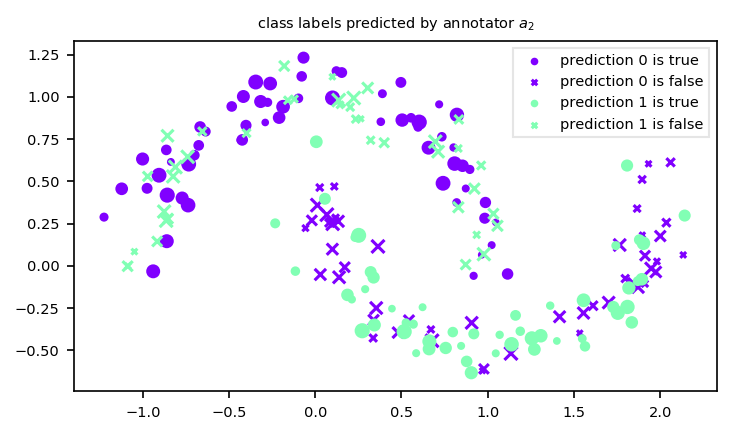

In [9]:
std_annot.plot_class_labels(X=X, y_true=y_true, annotator_ids=[2])
plt.tight_layout()
plt.show()

To create these graphs, the user is required to specify the samples `X` to be plotted.
Additionally, the user can provide the true class labels `y_true` of these samples, so that the correctness of a prediction is illustrated, where a false prediction is indicated by a cross and a correct prediction is indicated by a circle.
Moreover, the user may define the boolean parameter `plot_confidences=True`. As a result, the plotted samples have different sizes, which are proportional to the confidence scores of the corresponding class labels. 

## Confidence Noise
The most simulations provide the true confidence scores for the class labels provided by the annotators.
However, to test methods that rely on such confidence scores, it may be interesting how noise affects their performances.
Hence, noise can be put on confidence scores. 
This is also especially important, if we aim at simulating annotators with a bad self-assessment.

In [10]:
std_annot_noise = StandardAnnot(X=X, Y=Y, C=C.copy(), 
                                confidence_noise=[0.6]*n_annotators)
print('The confidences C and the C_ of the annotators are unequal: '
      +str(not np.array_equiv(C, std_annot_noise.C_)))

The confidences C and the C_ of the annotators are unequal: True


The original confidence scores are altered by adding noise sampled from $U(-0.6, 0.6)$ for each annotator. This is defined by the `confidence_noise` array. The entry `confidence_noise[i] = r` defines the noise sampling distribution $U(-r, r)$ of annotator $a_i$.